# Eval Run Plots

Plots loss, AUC, and accuracy curves for each run listed in `run_details.json`.
Best values are highlighted with markers. Baseline results are loaded from `baseline_results.json`.

In [385]:
import json
from pathlib import Path
from typing import Any, Dict, List, Optional

import matplotlib.pyplot as plt
import pandas as pd


def resolve_path(path_str: str) -> Path:
    """Resolve path from multiple candidate locations."""
    path = Path(path_str)
    candidates = [
        path,
        Path(path.name),
        Path('evals') / path.name,
        Path('..') / path,
    ]
    for candidate in candidates:
        if candidate.exists():
            return candidate
    return path


def generate_run_name(run: Dict[str, Any]) -> str:
    """Generate a unique/differentiator name from run parameters or run_id."""
    params = run.get('params')
    run_id = run.get('run_id', 'unknown')
    
    # Extract timestamp from run_id (e.g., temporal-vit-20260106-044352 -> 01/06-0443)
    parts = run_id.split('-')
    if len(parts) >= 4:
        date_part = parts[-2]  # e.g., 20260106
        time_part = parts[-1]  # e.g., 044352
        short_ts = f"{date_part[4:6]}/{date_part[6:8]}-{time_part[:4]}"
    else:
        short_ts = run_id[-12:] if len(run_id) > 12 else run_id
    
    if params and isinstance(params, dict):
        # Build name from key parameters
        name_parts = []
        
        # Key differentiating parameters
        param_abbrevs = {
            'n_trials': 'tr',
            'embed_dim': 'dim',
            'n_layers': 'L',
            'n_heads': 'H',
            'dropout': 'do',
            'drop_path': 'dp',
            'lr': 'lr',
            'weight_decay': 'wd',
            'label_smoothing': 'ls',
            'batch_size': 'bs',
        }
        
        for key, abbrev in param_abbrevs.items():
            if key in params:
                val = params[key]
                if isinstance(val, float):
                    if val < 0.01:
                        val_str = f"{val:.0e}"
                    else:
                        val_str = f"{val:.2g}"
                else:
                    val_str = str(val)
                name_parts.append(f"{abbrev}{val_str}")
        
        if name_parts:
            return f"{short_ts} ({', '.join(name_parts[:4])})"
    
    return short_ts


def extract_metrics_df(run: Dict[str, Any]) -> pd.DataFrame:
    """Extract metrics from run into a DataFrame."""
    metrics = run.get('metrics', [])
    if not metrics:
        return pd.DataFrame()
    
    df = pd.DataFrame(metrics)
    # Filter to training epochs only (exclude test-only rows)
    if 'val/loss' in df.columns:
        df = df.dropna(subset=['val/loss'])
    return df


def load_baselines(path_str: str = 'evals/baseline_results.json') -> List[Dict[str, Any]]:
    """Load baseline results from JSON file."""
    path = resolve_path(path_str)
    if not path.exists():
        print(f"Baseline results not found at {path}. Run collect_baseline_results.py first.")
        return []
    
    with open(path, 'r', encoding='utf-8') as handle:
        payload = json.load(handle)
    return payload.get('baselines', [])


# Load run details
run_details_path = resolve_path('evals/run_details.json')
if not run_details_path.exists():
    run_details_path = resolve_path('run_details.json')

with open(run_details_path, 'r', encoding='utf-8') as handle:
    payload = json.load(handle)

runs = payload.get('runs', [])
if not runs:
    raise ValueError('No runs found in run_details.json')

baselines = load_baselines()

print(f"Found {len(runs)} runs")
print(f"Found {len(baselines)} baseline results")


Found 3 runs
Found 2 baseline results


In [386]:
# Load HP tuning run details (optional)
hptune_details_path = resolve_path('evals/hptune_run_details.json')
if not hptune_details_path.exists():
    hptune_details_path = resolve_path('hptune_run_details.json')

hptune_runs = []
if hptune_details_path.exists():
    with open(hptune_details_path, 'r', encoding='utf-8') as handle:
        hptune_payload = json.load(handle)
    hptune_runs = hptune_payload.get('runs', [])
    print(f"Found {len(hptune_runs)} HP tuning runs")
else:
    print(f"HP tuning details not found at {hptune_details_path}")

def summarize_hptune_runs(runs):
    rows = []
    for run in runs:
        summary = run.get('summary', {})
        run_id = run.get('run_id') or 'unknown'
        val_auc = summary.get('best_val_auc')
        test_auc = summary.get('last_test_auc')
        if val_auc is None and test_auc is None:
            continue
        rows.append({
            'run_id': run_id,
            'val_auc': val_auc,
            'test_auc': test_auc,
            'summary': summary,
        })
    return rows

hptune_data = summarize_hptune_runs(hptune_runs)
print(f"HP runs with summary metrics: {len(hptune_data)}")


HP tuning details not found at hptune_run_details.json
HP runs with summary metrics: 0


In [387]:
# Prepare data for each run
run_data = []
for run in runs:
    df = extract_metrics_df(run)
    if df.empty:
        continue
    
    name = generate_run_name(run)
    run_data.append({
        'name': name,
        'run_id': run.get('run_id'),
        'df': df,
        'summary': run.get('summary', {}),
    })

print(f"Runs with metrics: {len(run_data)}")
for rd in run_data:
    print(f"  - {rd['name']}: {len(rd['df'])} epochs")

print('\nBaselines:')
for bl in baselines:
    test_auc = bl.get('test', {}).get('auc')
    test_acc = bl.get('test', {}).get('acc')
    auc_str = f"{test_auc:.4f}" if isinstance(test_auc, float) else 'N/A'
    acc_str = f"{test_acc:.4f}" if isinstance(test_acc, float) else 'N/A'
    print(f"  - {bl['name']}: test_auc={auc_str}, test_acc={acc_str}")


Runs with metrics: 3
  - 01/06-0443: 20 epochs
  - 01/06-1731: 1 epochs
  - 01/06-2253: 20 epochs

Baselines:
  - LogReg (no reg) [0727]: test_auc=0.8820, test_acc=0.5082
  - LogReg (C=0.1) [2250]: test_auc=0.8478, test_acc=0.5294


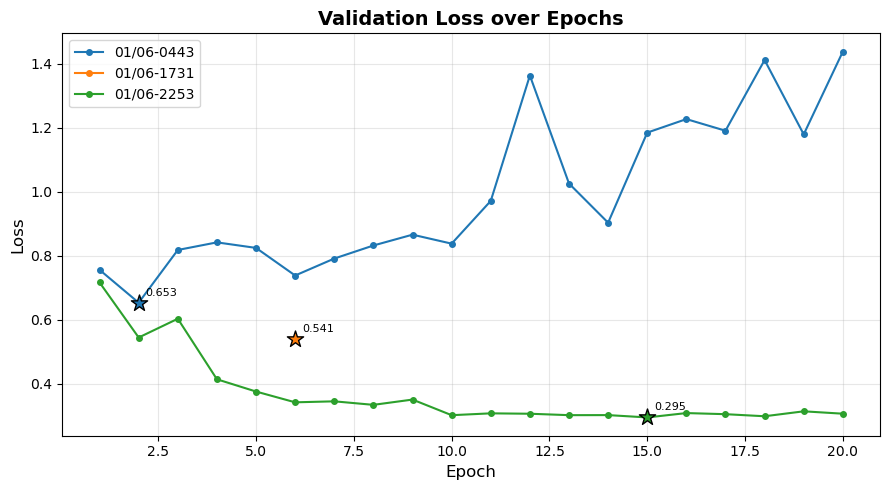

In [388]:
# Plot 1: Loss over epochs
fig, ax = plt.subplots(figsize=(9, 5))

for rd in run_data:
    df = rd['df']
    name = rd['name']
    
    if 'val/loss' not in df.columns or 'step' not in df.columns:
        continue
    
    epochs = df['step'].values
    val_loss = df['val/loss'].values
    
    # Plot the line
    line, = ax.plot(epochs, val_loss, marker='o', markersize=4, label=name)
    
    # Highlight best (minimum) loss
    best_idx = val_loss.argmin()
    best_epoch = epochs[best_idx]
    best_val = val_loss[best_idx]
    ax.scatter([best_epoch], [best_val], s=150, c=line.get_color(), 
               marker='*', edgecolors='black', linewidths=1, zorder=5)
    ax.annotate(f'{best_val:.3f}', (best_epoch, best_val), 
                textcoords='offset points', xytext=(5, 5), fontsize=8)

ax.set_title('Validation Loss over Epochs', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()


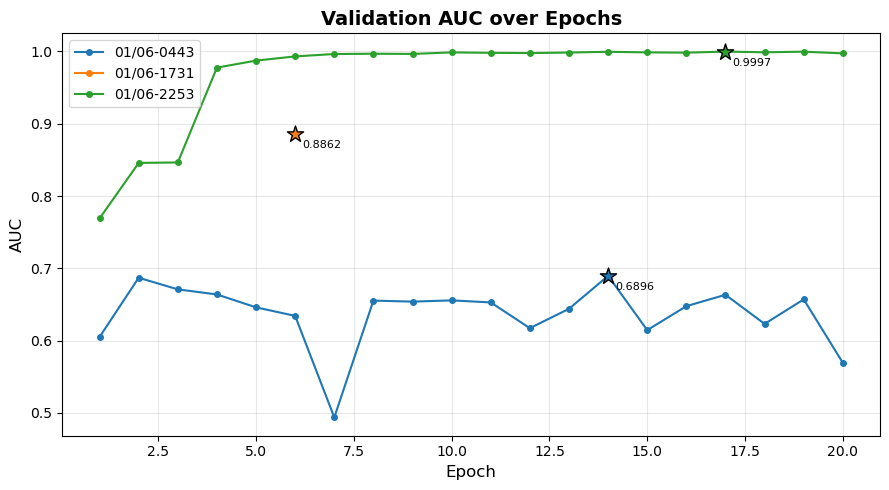

In [389]:
# Plot 2: Validation AUC over epochs
fig, ax = plt.subplots(figsize=(9, 5))

for rd in run_data:
    df = rd['df']
    name = rd['name']
    
    if 'val/auc' not in df.columns or 'step' not in df.columns:
        continue
    
    epochs = df['step'].values
    val_auc = df['val/auc'].values
    
    # Plot the line
    line, = ax.plot(epochs, val_auc, marker='o', markersize=4, label=name)
    
    # Highlight best (maximum) AUC
    best_idx = val_auc.argmax()
    best_epoch = epochs[best_idx]
    best_val = val_auc[best_idx]
    ax.scatter([best_epoch], [best_val], s=150, c=line.get_color(), 
               marker='*', edgecolors='black', linewidths=1, zorder=5)
    ax.annotate(f'{best_val:.4f}', (best_epoch, best_val), 
                textcoords='offset points', xytext=(5, -10), fontsize=8)

ax.set_title('Validation AUC over Epochs', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('AUC', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()


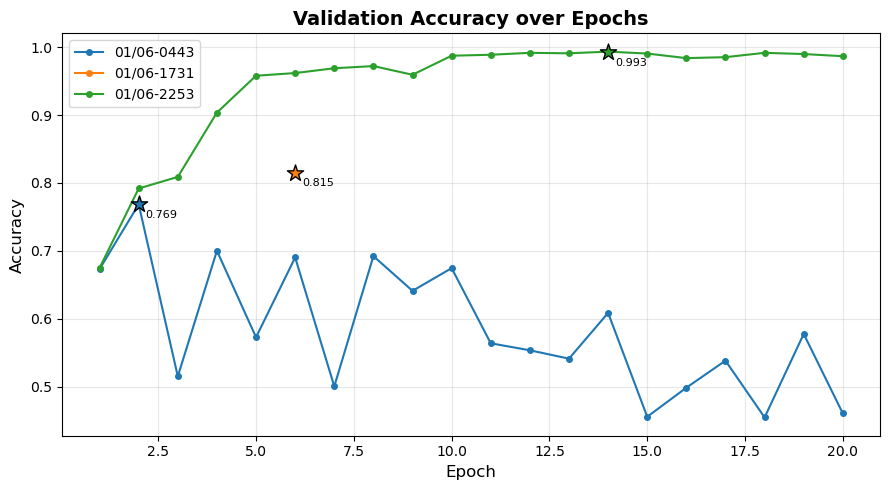

In [390]:
# Plot 3: Validation Accuracy over epochs
fig, ax = plt.subplots(figsize=(9, 5))

for rd in run_data:
    df = rd['df']
    name = rd['name']
    
    if 'val/acc' not in df.columns or 'step' not in df.columns:
        continue
    
    epochs = df['step'].values
    val_acc = df['val/acc'].values
    
    # Plot the line
    line, = ax.plot(epochs, val_acc, marker='o', markersize=4, label=name)
    
    # Highlight best (maximum) accuracy
    best_idx = val_acc.argmax()
    best_epoch = epochs[best_idx]
    best_val = val_acc[best_idx]
    ax.scatter([best_epoch], [best_val], s=150, c=line.get_color(), 
               marker='*', edgecolors='black', linewidths=1, zorder=5)
    ax.annotate(f'{best_val:.3f}', (best_epoch, best_val), 
                textcoords='offset points', xytext=(5, -10), fontsize=8)

ax.set_title('Validation Accuracy over Epochs', fontsize=14, fontweight='bold')
ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Accuracy', fontsize=12)
ax.grid(True, alpha=0.3)
ax.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()


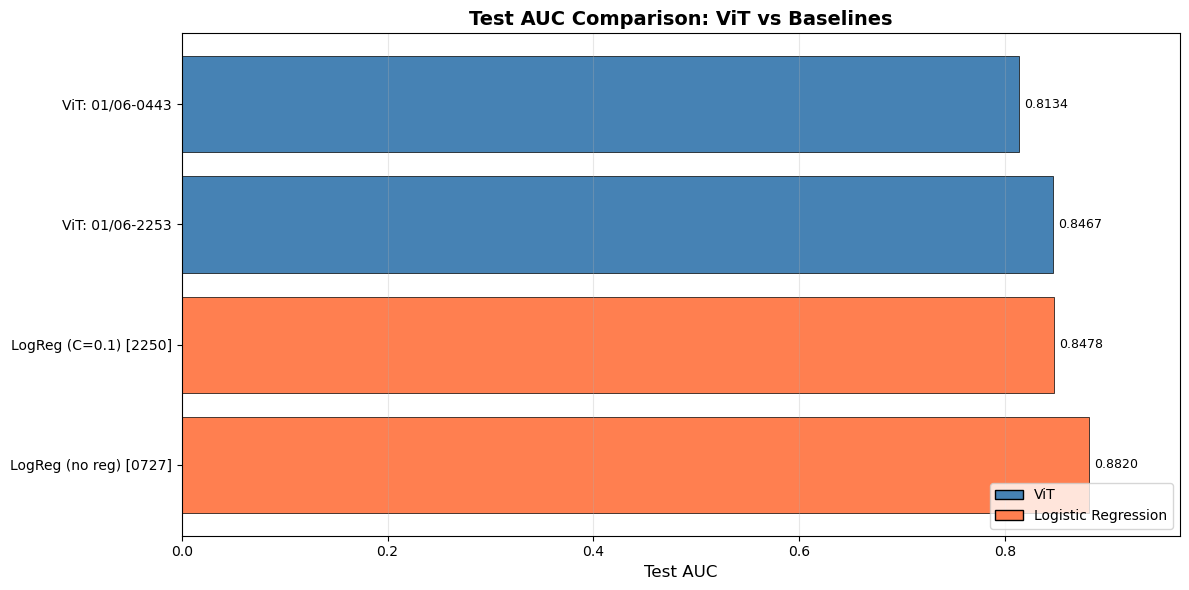

In [391]:
# Plot 4: Test AUC comparison (ViT vs baselines)
fig, ax = plt.subplots(figsize=(12, 6))

model_names = []
test_aucs = []
colors = []

for rd in run_data:
    test_auc = rd['summary'].get('last_test_auc')
    if isinstance(test_auc, float):
        model_names.append(f"ViT: {rd['name']}")
        test_aucs.append(test_auc)
        colors.append('steelblue')

baseline_color_map = {
    'log_reg': 'coral',
    'logistic_regression': 'coral',
    'xgboost': 'forestgreen',
    'random_forest': 'purple',
}
for bl in baselines:
    test_auc = bl.get('test', {}).get('auc')
    if isinstance(test_auc, float):
        model_names.append(bl['name'])
        test_aucs.append(test_auc)
        colors.append(baseline_color_map.get(bl.get('model_type', ''), 'gray'))

if not test_aucs:
    print('No test AUC values available to plot.')
else:
    sorted_indices = sorted(range(len(test_aucs)), key=lambda i: test_aucs[i], reverse=True)
    model_names = [model_names[i] for i in sorted_indices]
    test_aucs = [test_aucs[i] for i in sorted_indices]
    colors = [colors[i] for i in sorted_indices]

    bars = ax.barh(range(len(model_names)), test_aucs, color=colors, edgecolor='black', linewidth=0.5)
    for bar, auc in zip(bars, test_aucs):
        ax.text(auc + 0.005, bar.get_y() + bar.get_height() / 2, f'{auc:.4f}',
                va='center', ha='left', fontsize=9)

    ax.set_yticks(range(len(model_names)))
    ax.set_yticklabels(model_names, fontsize=10)
    ax.set_xlabel('Test AUC', fontsize=12)
    ax.set_title('Test AUC Comparison: ViT vs Baselines', fontsize=14, fontweight='bold')
    ax.set_xlim(0, max(test_aucs) * 1.1)
    ax.grid(True, alpha=0.3, axis='x')

    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='steelblue', edgecolor='black', label='ViT'),
        Patch(facecolor='coral', edgecolor='black', label='Logistic Regression'),
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

    plt.tight_layout()
    plt.show()


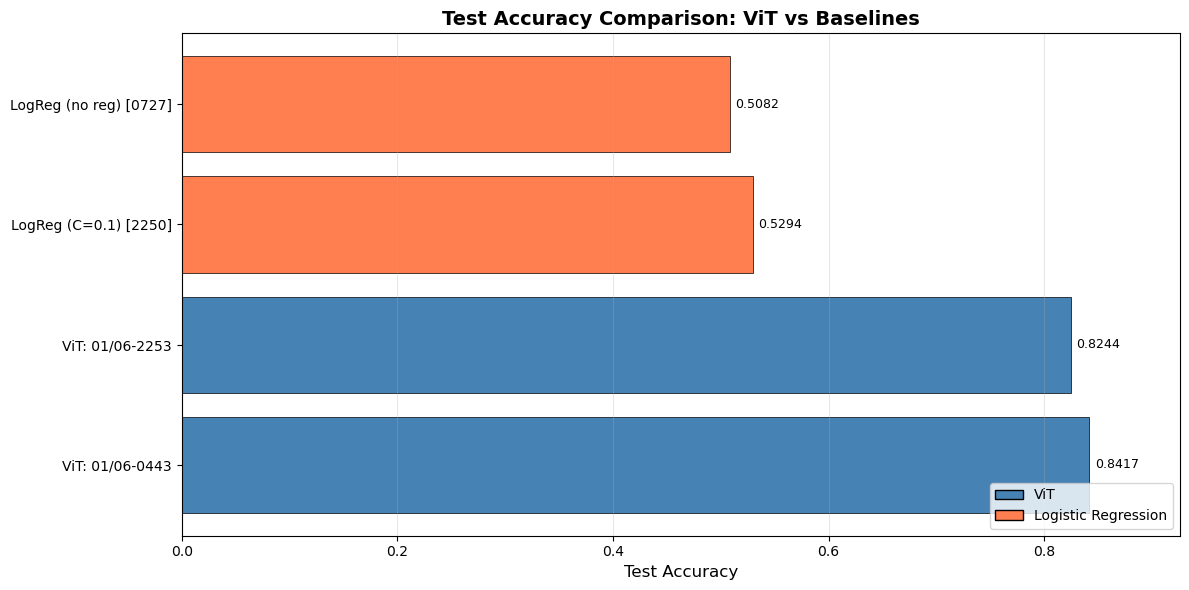

In [392]:
# Plot 5: Test Accuracy comparison (ViT vs baselines)
fig, ax = plt.subplots(figsize=(12, 6))

model_names = []
test_accs = []
colors = []

for rd in run_data:
    test_acc = rd['summary'].get('last_test_acc')
    if isinstance(test_acc, float):
        model_names.append(f"ViT: {rd['name']}")
        test_accs.append(test_acc)
        colors.append('steelblue')

baseline_color_map = {
    'log_reg': 'coral',
    'logistic_regression': 'coral',
    'xgboost': 'forestgreen',
    'random_forest': 'purple',
}
for bl in baselines:
    test_acc = bl.get('test', {}).get('acc')
    if isinstance(test_acc, float):
        model_names.append(bl['name'])
        test_accs.append(test_acc)
        colors.append(baseline_color_map.get(bl.get('model_type', ''), 'gray'))

if not test_accs:
    print('No test accuracy values available to plot.')
else:
    sorted_indices = sorted(range(len(test_accs)), key=lambda i: test_accs[i], reverse=True)
    model_names = [model_names[i] for i in sorted_indices]
    test_accs = [test_accs[i] for i in sorted_indices]
    colors = [colors[i] for i in sorted_indices]

    bars = ax.barh(range(len(model_names)), test_accs, color=colors, edgecolor='black', linewidth=0.5)
    for bar, acc in zip(bars, test_accs):
        ax.text(acc + 0.005, bar.get_y() + bar.get_height() / 2, f'{acc:.4f}',
                va='center', ha='left', fontsize=9)

    ax.set_yticks(range(len(model_names)))
    ax.set_yticklabels(model_names, fontsize=10)
    ax.set_xlabel('Test Accuracy', fontsize=12)
    ax.set_title('Test Accuracy Comparison: ViT vs Baselines', fontsize=14, fontweight='bold')
    ax.set_xlim(0, max(test_accs) * 1.1)
    ax.grid(True, alpha=0.3, axis='x')

    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='steelblue', edgecolor='black', label='ViT'),
        Patch(facecolor='coral', edgecolor='black', label='Logistic Regression'),
    ]
    ax.legend(handles=legend_elements, loc='lower right', fontsize=10)

    plt.tight_layout()
    plt.show()


In [393]:
# Summary table with baselines
summary_data = []

for rd in run_data:
    df = rd['df']
    summary = rd['summary']
    
    row = {
        'Model': 'ViT',
        'Run': rd['name'],
        'Epochs': len(df),
        'Best Val AUC': summary.get('best_val_auc'),
        'Best AUC Epoch': summary.get('best_val_auc_step'),
        'Test AUC': summary.get('last_test_auc'),
        'Test Acc': summary.get('last_test_acc'),
    }
    summary_data.append(row)

for bl in baselines:
    row = {
        'Model': bl.get('model_type', 'baseline'),
        'Run': bl['name'],
        'Epochs': '-',
        'Best Val AUC': bl.get('val', {}).get('auc'),
        'Best AUC Epoch': '-',
        'Test AUC': bl.get('test', {}).get('auc'),
        'Test Acc': bl.get('test', {}).get('acc'),
    }
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
summary_df['_sort_key'] = summary_df['Test AUC'].apply(lambda x: x if isinstance(x, float) else -1)
summary_df = summary_df.sort_values('_sort_key', ascending=False).drop(columns=['_sort_key'])

display(summary_df)


,Model,Run,Epochs,Best Val AUC,Best AUC Epoch,Test AUC,Test Acc
3,log_reg,LogReg (no reg) [0727],-,0.995302,-,0.882024,0.508215
4,log_reg,LogReg (C=0.1) [2250],-,0.997281,-,0.847822,0.529390
2,ViT,01/06-2253,20,0.999687,17,0.846688,0.824388
0,ViT,01/06-0443,20,0.689596,14,0.813363,0.841681
1,ViT,01/06-1731,1,0.886183,6,NaN,NaN


In [ ]:
# Save params for a specific HP run (from hptune_run_1_details.json)
from pathlib import Path
import json

target_run = '8-041936'
details_path = resolve_path('evals/hptune_run_1_details.json')
if not details_path.exists():
    details_path = resolve_path('hptune_run_1_details.json')

def run_matches(run_id: str, target: str) -> bool:
    if not run_id:
        return False
    if target in run_id:
        return True
    short_id = run_id[-8:] if len(run_id) > 8 else run_id
    return short_id == target

if not details_path.exists():
    print(f'Run details not found at {details_path}')
else:
    with open(details_path, 'r', encoding='utf-8') as handle:
        payload = json.load(handle)
    runs = payload.get('runs', [])
    matched_run = None
    for run in runs:
        run_id = run.get('run_id') or ''
        if run_matches(run_id, target_run):
            matched_run = run
            break

    if not matched_run:
        print(f'Run {target_run} not found in {details_path}')
    else:
        params = matched_run.get('params')
        out_dir = Path('evals')
        out_dir.mkdir(parents=True, exist_ok=True)
        out_path = out_dir / f'hptune_params_{target_run}.json'
        out_path.write_text(json.dumps({
            'run_id': matched_run.get('run_id'),
            'params': params,
        }, indent=2), encoding='utf-8')
        print(f'Saved params to {out_path}')


Saved params to evals/hptune_params_8-041936.json


In [ ]:
# Plot: Hyperparameters vs Test AUC for HP Tuning Trials
import numpy as np

# Load HP tuning run details
hp_details_path = resolve_path('evals/hptune_run_1_details.json')
if not hp_details_path.exists():
    hp_details_path = resolve_path('hptune_run_1_details.json')

if not hp_details_path.exists():
    print(f'HP tuning details not found at {hp_details_path}')
else:
    with open(hp_details_path, 'r', encoding='utf-8') as handle:
        hp_payload = json.load(handle)
    hp_runs = hp_payload.get('runs', [])
    
    # Extract hyperparameters and test AUC for each trial
    hp_data = []
    for run in hp_runs:
        summary = run.get('summary', {})
        params = run.get('params', {})
        test_auc = summary.get('last_test_auc')
        if test_auc is not None and isinstance(test_auc, (int, float)):
            hp_data.append({
                'run_id': run.get('run_id', 'unknown'),
                'test_auc': test_auc,
                **{k: v for k, v in params.items() if isinstance(v, (int, float))}
            })
    
    if not hp_data:
        print('No HP tuning runs with test AUC found.')
    else:
        hp_df = pd.DataFrame(hp_data)
        print(f'Found {len(hp_df)} HP tuning trials with test AUC')
        
        # Identify hyperparameters that vary across trials
        # These are the ones we searched over
        searched_hps = []
        exclude_cols = {'run_id', 'test_auc', 'n_trials', 'epochs', 'warmup_epochs', 
                        'early_stopping_patience', 'batch_size', 'stride',
                        'train_sequences', 'val_sequences', 'test_sequences',
                        'n_heads', 'n_layers', 'embed_dim', 'min_lr'}
        
        for col in hp_df.columns:
            if col in exclude_cols:
                continue
            if hp_df[col].nunique() > 1:
                searched_hps.append(col)
        
        print(f'Searched hyperparameters: {searched_hps}')
        
        # Create subplots for each hyperparameter
        n_hps = len(searched_hps)
        if n_hps > 0:
            n_cols = min(3, n_hps)
            n_rows = (n_hps + n_cols - 1) // n_cols
            
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
            if n_hps == 1:
                axes = np.array([axes])
            axes = axes.flatten() if n_hps > 1 else [axes]
            
            # Color by test AUC
            test_aucs = hp_df['test_auc'].values
            best_idx = np.argmax(test_aucs)
            
            for i, hp_name in enumerate(searched_hps):
                ax = axes[i]
                x = hp_df[hp_name].values
                y = test_aucs
                
                # Scatter plot
                scatter = ax.scatter(x, y, c=y, cmap='viridis', s=80, edgecolors='black', linewidths=0.5, alpha=0.8)
                
                # Highlight best point
                ax.scatter([x[best_idx]], [y[best_idx]], s=200, c='red', marker='*', 
                           edgecolors='black', linewidths=1, zorder=5, label='Best')
                
                # Add trend line
                if len(x) > 2:
                    z = np.polyfit(x, y, 1)
                    p = np.poly1d(z)
                    x_line = np.linspace(x.min(), x.max(), 100)
                    ax.plot(x_line, p(x_line), 'r--', alpha=0.5, linewidth=2)
                    
                    # Calculate correlation
                    corr = np.corrcoef(x, y)[0, 1]
                    ax.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax.transAxes, 
                            fontsize=10, verticalalignment='top',
                            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
                
                ax.set_xlabel(hp_name, fontsize=11)
                ax.set_ylabel('Test AUC', fontsize=11)
                ax.set_title(f'{hp_name} vs Test AUC', fontsize=12, fontweight='bold')
                ax.grid(True, alpha=0.3)
            
            # Hide unused axes
            for j in range(n_hps, len(axes)):
                axes[j].set_visible(False)
            
            plt.suptitle('Hyperparameter Search: Parameter vs Test AUC', fontsize=14, fontweight='bold', y=1.02)
            plt.tight_layout()
            plt.show()
            
            # Print best configuration
            print('\n--- Best Configuration ---')
            best_run = hp_df.iloc[best_idx]
            print(f"Run ID: {best_run['run_id']}")
            print(f"Test AUC: {best_run['test_auc']:.4f}")
            print('Hyperparameters:')
            for hp in searched_hps:
                print(f"  {hp}: {best_run[hp]}")


In [ ]:
# Plot: Hyperparameters vs Test AUC for Multiple HP Tuning Runs
import numpy as np

def plot_hp_vs_testauc(hp_details_path: str, run_label: str):
    """Plot hyperparameter vs test AUC scatter plots for a given HP tuning run."""
    path = resolve_path(hp_details_path)
    if not path.exists():
        print(f'HP tuning details not found at {path}')
        return None
    
    with open(path, 'r', encoding='utf-8') as handle:
        hp_payload = json.load(handle)
    hp_runs = hp_payload.get('runs', [])
    
    # Extract hyperparameters and test AUC for each trial
    hp_data = []
    for run in hp_runs:
        summary = run.get('summary', {})
        params = run.get('params', {})
        test_auc = summary.get('last_test_auc')
        if test_auc is not None and isinstance(test_auc, (int, float)):
            hp_data.append({
                'run_id': run.get('run_id', 'unknown'),
                'test_auc': test_auc,
                **{k: v for k, v in params.items() if isinstance(v, (int, float))}
            })
    
    if not hp_data:
        print(f'No HP tuning runs with test AUC found in {run_label}.')
        return None
    
    hp_df = pd.DataFrame(hp_data)
    print(f'\n{"="*60}')
    print(f'{run_label}: Found {len(hp_df)} HP tuning trials with test AUC')
    print(f'{"="*60}')
    
    # Identify hyperparameters that vary across trials
    searched_hps = []
    exclude_cols = {'run_id', 'test_auc', 'n_trials', 'epochs', 'warmup_epochs', 
                    'early_stopping_patience', 'stride',
                    'train_sequences', 'val_sequences', 'test_sequences',
                    'n_heads', 'n_layers', 'embed_dim', 'min_lr',
                    'lr_base', 'lr_scale_factor'}  # exclude derived lr params
    
    for col in hp_df.columns:
        if col in exclude_cols:
            continue
        if hp_df[col].nunique() > 1:
            searched_hps.append(col)
    
    print(f'Searched hyperparameters: {searched_hps}')
    
    # Create subplots for each hyperparameter
    n_hps = len(searched_hps)
    if n_hps == 0:
        print('No varying hyperparameters found.')
        return hp_df
    
    n_cols = min(3, n_hps)
    n_rows = (n_hps + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    if n_hps == 1:
        axes = np.array([axes])
    axes = axes.flatten() if n_hps > 1 else [axes]
    
    # Color by test AUC
    test_aucs = hp_df['test_auc'].values
    best_idx = np.argmax(test_aucs)
    
    for i, hp_name in enumerate(searched_hps):
        ax = axes[i]
        x = hp_df[hp_name].values
        y = test_aucs
        
        # Scatter plot
        scatter = ax.scatter(x, y, c=y, cmap='viridis', s=80, edgecolors='black', linewidths=0.5, alpha=0.8)
        
        # Highlight best point
        ax.scatter([x[best_idx]], [y[best_idx]], s=200, c='red', marker='*', 
                   edgecolors='black', linewidths=1, zorder=5, label='Best')
        
        # Add trend line
        if len(x) > 2:
            try:
                z = np.polyfit(x, y, 1)
                p = np.poly1d(z)
                x_line = np.linspace(x.min(), x.max(), 100)
                ax.plot(x_line, p(x_line), 'r--', alpha=0.5, linewidth=2)
                
                # Calculate correlation
                corr = np.corrcoef(x, y)[0, 1]
                ax.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax.transAxes, 
                        fontsize=10, verticalalignment='top',
                        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            except Exception:
                pass
        
        ax.set_xlabel(hp_name, fontsize=11)
        ax.set_ylabel('Test AUC', fontsize=11)
        ax.set_title(f'{hp_name} vs Test AUC', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3)
    
    # Hide unused axes
    for j in range(n_hps, len(axes)):
        axes[j].set_visible(False)
    
    plt.suptitle(f'{run_label}: Hyperparameter vs Test AUC', fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Print best configuration
    print(f'\n--- {run_label} Best Configuration ---')
    best_run = hp_df.iloc[best_idx]
    print(f"Run ID: {best_run['run_id']}")
    print(f"Test AUC: {best_run['test_auc']:.4f}")
    print('Hyperparameters:')
    for hp in searched_hps:
        print(f"  {hp}: {best_run[hp]}")
    
    return hp_df


# Plot HP Run 1
hp_df_run1 = plot_hp_vs_testauc('evals/hptune_run_1_details.json', 'HP Tuning Run 1')

# Plot HP Run 2
hp_df_run2 = plot_hp_vs_testauc('evals/hptune_run_2_details.json', 'HP Tuning Run 2')


In [ ]:
# Summary comparison of HP Tuning Run 1 vs Run 2

def summarize_hp_run(hp_df, run_label):
    """Summarize statistics for an HP tuning run."""
    if hp_df is None or hp_df.empty:
        return None
    
    return {
        'Run': run_label,
        'Trials': len(hp_df),
        'Best Test AUC': hp_df['test_auc'].max(),
        'Mean Test AUC': hp_df['test_auc'].mean(),
        'Std Test AUC': hp_df['test_auc'].std(),
        'Min Test AUC': hp_df['test_auc'].min(),
    }

comparison_data = []
if hp_df_run1 is not None:
    comparison_data.append(summarize_hp_run(hp_df_run1, 'HP Run 1 (fixed bs=16)'))
if hp_df_run2 is not None:
    comparison_data.append(summarize_hp_run(hp_df_run2, 'HP Run 2 (bs=[8,16,32], LR scaling)'))

if comparison_data:
    comparison_df = pd.DataFrame([d for d in comparison_data if d is not None])
    print('\n' + '='*60)
    print('HP Tuning Runs Comparison')
    print('='*60)
    display(comparison_df)
    
    # Bar chart comparison
    if len(comparison_df) > 1:
        fig, ax = plt.subplots(figsize=(10, 5))
        x = np.arange(len(comparison_df))
        width = 0.25
        
        bars1 = ax.bar(x - width, comparison_df['Best Test AUC'], width, label='Best', color='forestgreen')
        bars2 = ax.bar(x, comparison_df['Mean Test AUC'], width, label='Mean', color='steelblue')
        bars3 = ax.bar(x + width, comparison_df['Min Test AUC'], width, label='Min', color='coral')
        
        ax.set_ylabel('Test AUC')
        ax.set_title('HP Tuning Runs: Test AUC Comparison', fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(comparison_df['Run'])
        ax.legend()
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels
        for bars in [bars1, bars2, bars3]:
            for bar in bars:
                height = bar.get_height()
                ax.annotate(f'{height:.3f}',
                            xy=(bar.get_x() + bar.get_width() / 2, height),
                            xytext=(0, 3), textcoords='offset points',
                            ha='center', va='bottom', fontsize=8)
        
        plt.tight_layout()
        plt.show()
else:
    print('No HP tuning data available for comparison.')
